In [1]:
import random
import torch
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
from timeit import default_timer
from scipy.io import loadmat
import yaml
import gc

sys.path.append("../")


from models import  newHGkNN_train, compute_2dFourier_bases, compute_2dpca_bases, compute_2dFourier_cbases, count_params

from models.myGkNN11 import newHGkNN

torch.set_printoptions(precision=16)


torch.manual_seed(0)
np.random.seed(0)


###################################
# load configs
###################################
with open('config.yml', 'r', encoding='utf-8') as f:
    config = yaml.full_load(f)

config = config["Darcy_HGkNN"]
config = dict(config)
config_data, config_model, config_train = (
    config["data"],
    config["model"],
    config["train"],
)
downsample_ratio = config_data["downsample_ratio"]
L = config_data["L"]
n_train = config_data["n_train"]
n_test = config_data["n_test"]
device = torch.device(config["train"]["device"])


###################################
# load data
###################################
# data_path = "../data/darcy_2d/piececonst_r421_N1024_smooth1"
# data1 = loadmat(data_path)
# coeff1 = data1["coeff"]
# sol1 = data1["sol"]
# del data1
# data_path = "../data/darcy_2d/piececonst_r421_N1024_smooth2"
# data2 = loadmat(data_path)
# coeff2 = data2["coeff"][:300,:,:]
# sol2 = data2["sol"][:300,:,:]
# del data2
# gc.collect()

# data_in = np.vstack((coeff1, coeff2))  # shape: 2048,421,421
# data_out = np.vstack((sol1, sol2))     # shape: 2048,421,421

data_path = "../data/darcy_2d/piececonst_r421_N1024_smooth1"
data1 = loadmat(data_path)

data_in = data1["coeff"]
data_out = data1["sol"]
print("data_in.shape:" , data_in.shape)
print("data_out.shape", data_out.shape)

Np_ref = data_in.shape[1]
grid_1d = np.linspace(0, L, Np_ref)
grid_x, grid_y = np.meshgrid(grid_1d, grid_1d)

data_in_ds = data_in[0:n_train, 0::downsample_ratio, 0::downsample_ratio]
grid_x_ds = grid_x[0::downsample_ratio, 0::downsample_ratio]
grid_y_ds = grid_y[0::downsample_ratio, 0::downsample_ratio]
data_out_ds = data_out[0:n_train, 0::downsample_ratio, 0::downsample_ratio]

# x_train, y_train are [n_data, n_x, n_channel] arrays
x_train = torch.from_numpy(
    np.stack(
        (
            data_in_ds,
            np.tile(grid_x_ds, (n_train, 1, 1)),
            np.tile(grid_y_ds, (n_train, 1, 1)),
        ),
        axis=-1,
    ).astype(np.float32)
)
y_train = torch.from_numpy(data_out_ds[:, :, :, np.newaxis].astype(np.float32))
# x_test, y_test are [n_data, n_x, n_channel] arrays
x_test = torch.from_numpy(
    np.stack(
        (
            data_in[-n_test:, 0::downsample_ratio, 0::downsample_ratio],
            np.tile(grid_x[0::downsample_ratio, 0::downsample_ratio], (n_test, 1, 1)),
            np.tile(grid_y[0::downsample_ratio, 0::downsample_ratio], (n_test, 1, 1)),
        ),
        axis=-1,
    ).astype(np.float32)
)
y_test = torch.from_numpy(
    data_out[-n_test:, 0::downsample_ratio, 0::downsample_ratio, np.newaxis].astype(
        np.float32
    )
)

x_train = x_train.reshape(x_train.shape[0], -1, x_train.shape[-1])   # shape: 800,11236,3  (11236 = 106*106 , 106-1 = (421-1) /4)
x_test = x_test.reshape(x_test.shape[0], -1, x_test.shape[-1])
y_train = y_train.reshape(y_train.shape[0], -1, y_train.shape[-1])   # shape: 800,11236,1
y_test = y_test.reshape(y_test.shape[0], -1, y_test.shape[-1])
print("x_train.shape: ",x_train.shape)
print("y_train.shape: ",y_train.shape)




####################################
#compute pca bases
####################################
k_max = max(config_model['layer']["GkNN_mode_in"],config_model['layer']["GkNN_mode_out"])
Np = (Np_ref + downsample_ratio - 1) // downsample_ratio

gap = config_data['translation_gap']
num = config_data['translation_num']
print(f'Begin Translation:  translation_gap = {gap},translation_num = {num}')
pca_data_in = np.zeros((4*num+1,data_in_ds.shape[0],Np,Np))
pca_data_out = np.zeros((4*num+1,data_in_ds.shape[0],Np,Np))
pca_data_in[0] = data_in_ds
pca_data_out[0] = data_out_ds
data_in_ds_padded = np.zeros((data_in_ds.shape[0],Np + 2*gap*num,Np + 2*gap*num))
data_in_ds_padded[:,gap*num: Np + gap*num,gap*num: Np + gap*num] = data_in_ds
data_out_ds_padded = np.zeros((data_out_ds.shape[0],Np + 2*gap*num,Np + 2*gap*num))
data_out_ds_padded[:,gap*num: Np + gap*num,gap*num: Np + gap*num] = data_out_ds
for i in range(1,num+1):
    pca_data_in[4*i-3] = data_in_ds_padded[:,gap*(num-i): Np + gap*(num-i),gap*(num-i): Np + gap*(num-i)]
    pca_data_in[4*i-2] = data_in_ds_padded[:,gap*(num+i): Np + gap*(num+i),gap*(num-i): Np + gap*(num-i)]
    pca_data_in[4*i-1] = data_in_ds_padded[:,gap*(num-i): Np + gap*(num-i),gap*(num+i): Np + gap*(num+i)]
    pca_data_in[4*i] = data_in_ds_padded[:,gap*(num+i): Np + gap*(num+i),gap*(num+i): Np + gap*(num+i)]
    pca_data_out[4*i-3] = data_out_ds_padded[:,gap*(num-i): Np + gap*(num-i),gap*(num-i): Np + gap*(num-i)]
    pca_data_out[4*i-2] = data_out_ds_padded[:,gap*(num+i): Np + gap*(num+i),gap*(num-i): Np + gap*(num-i)]
    pca_data_out[4*i-1] = data_out_ds_padded[:,gap*(num-i): Np + gap*(num-i),gap*(num+i): Np + gap*(num+i)]
    pca_data_out[4*i] = data_out_ds_padded[:,gap*(num+i): Np + gap*(num+i),gap*(num+i): Np + gap*(num+i)]

pca_data_out = pca_data_out.reshape((4*num+1)*data_out_ds.shape[0],Np*Np)
pca_data_in = pca_data_in.reshape((4*num+1)*data_in_ds.shape[0],Np*Np)
# percentage = 0.1
# mask1 = torch.rand(pca_data_in.shape) > percentage
# mask2 = torch.rand(pca_data_out.shape) > percentage
# pca_data_in = (torch.from_numpy(pca_data_in)*mask1).numpy()
# pca_data_out = (torch.from_numpy(pca_data_out)*mask2).numpy()


print("Start SVD with data shape: ", pca_data_out.shape, flush = True)

bases_pca_in, wbases_pca_in = compute_2dpca_bases(Np , k_max , L,  pca_data_in)
bases_pca_in, wbases_pca_in = bases_pca_in.to(device), wbases_pca_in.to(device)

bases_pca_out, wbases_pca_out = compute_2dpca_bases(Np , k_max , L,  pca_data_out)
bases_pca_out, wbases_pca_out = bases_pca_out.to(device), wbases_pca_out.to(device)

data_in.shape: (1024, 421, 421)
data_out.shape (1024, 421, 421)
x_train.shape:  torch.Size([800, 961, 3])
y_train.shape:  torch.Size([800, 961, 1])
Begin Translation:  translation_gap = 1,translation_num = 10
Start SVD with data shape:  (32800, 961)


torch.Size([961, 128])


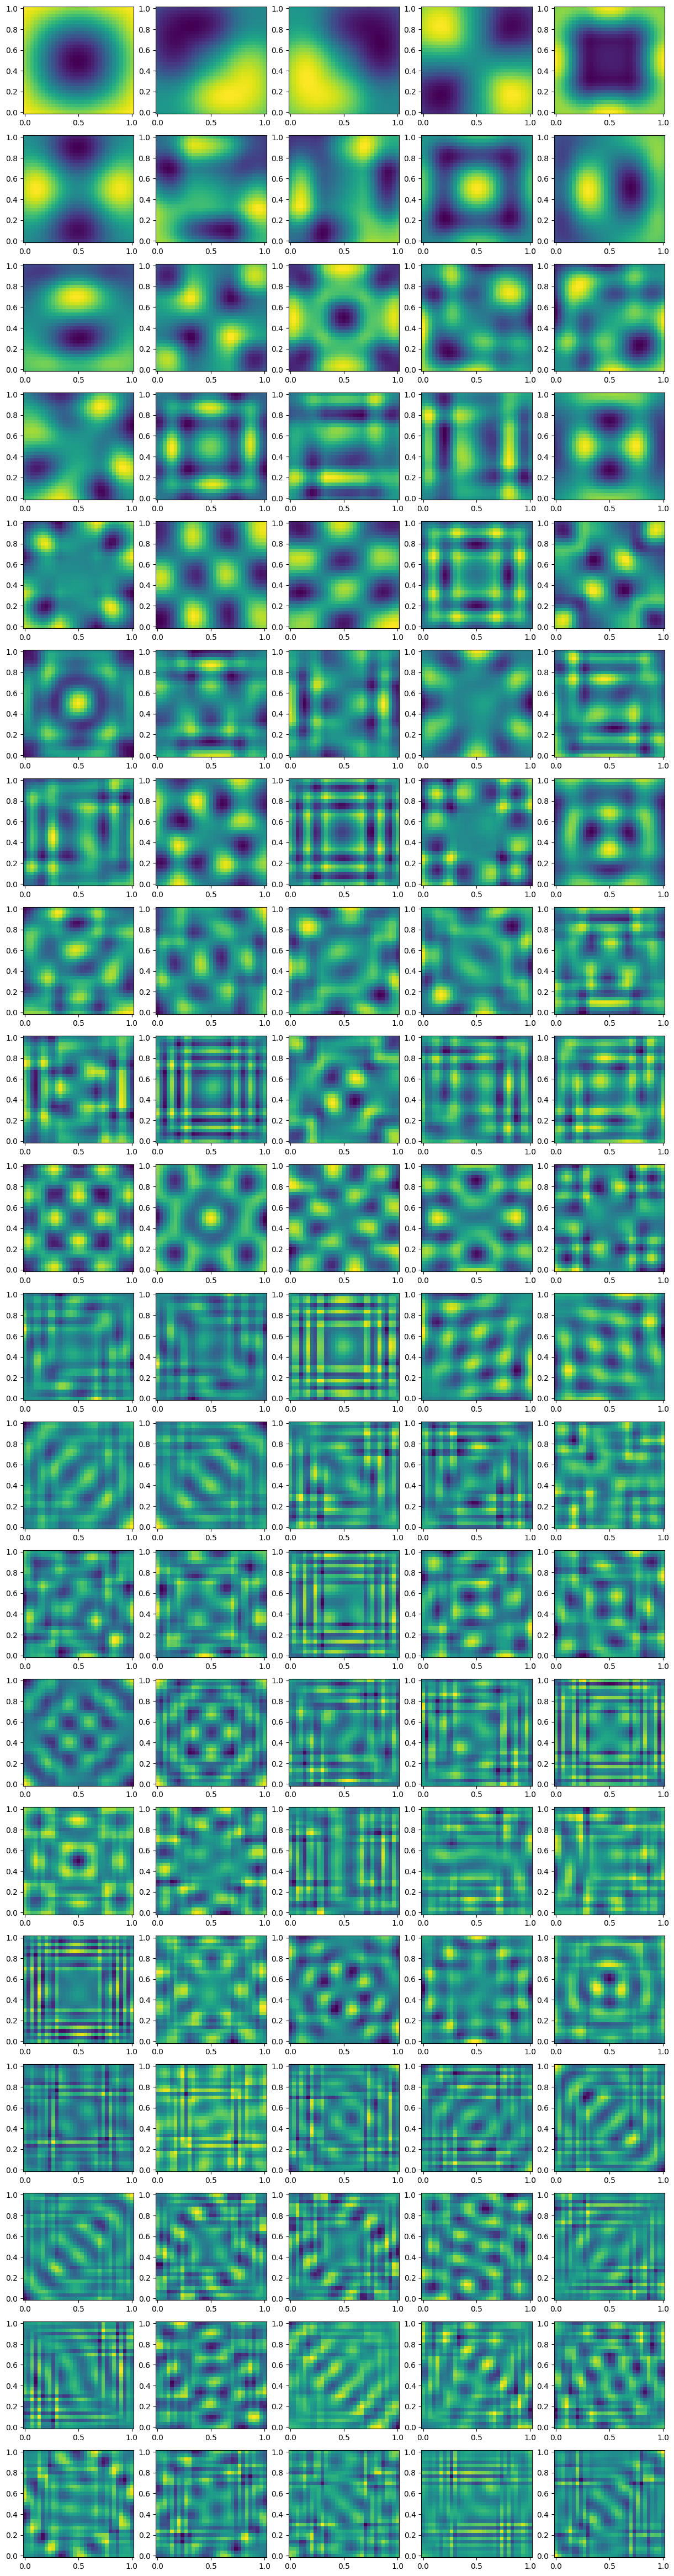

In [2]:
%matplotlib inline
print(bases_pca_out.shape)
bases_pca_2d = bases_pca_out.reshape(Np,Np,k_max).to('cpu')
wbases_pca_2d = wbases_pca_out.reshape(Np,Np,k_max).to('cpu')
mygrid = np.linspace(0, L, Np)
grid_x, grid_y = np.meshgrid(mygrid, mygrid)
m=20
n=5
fig, axs = plt.subplots(m, n, figsize=(3*n,3*m))
for i in range(5):
    for j in range(m):
        axs[j,i].pcolormesh(grid_x, grid_y, bases_pca_2d[:,:,i+j*n])


In [10]:
from models.losses import LpLoss
from models import  FNN_train, compute_2dFourier_bases, compute_2dpca_bases, UnitGaussianNormalizer
x_normalizer = UnitGaussianNormalizer(x_train, dim=[])
y_normalizer = UnitGaussianNormalizer(y_train, dim=[])
n=10
myloss = LpLoss(d=1, p=2, size_average=False)
# fig, axs = plt.subplots(n,2, figsize=(4*2,4*n))
# mygrid = np.linspace(0, L, Np)
# grid_x, grid_y = np.meshgrid(mygrid, mygrid)
for i in range(n):
    x = x_test[i,:,0].to(device)
    # x1 = x_normalizer.encode(x)
    # x1=x
    # x_hat = torch.einsum('x,xk -> k',x1,wbases_pca_in)
    # x0 = torch.einsum('k,xk -> x',x_hat,bases_pca_in)
    # # x0 = x_normalizer.decode(x0)
    # print('test',torch.norm(x0-x).item()/torch.norm(x).item())
    # print('xtest',myloss(x,x0).item())
    # # im=axs[i,0].pcolormesh(grid_x, grid_y, x.to('cpu').reshape(Np,Np))
    # # fig.colorbar(im, ax=axs[i,0])
    # # im=axs[i,1].pcolormesh(grid_x, grid_y, x0.to('cpu').reshape(Np,Np))
    # # fig.colorbar(im, ax=axs[i,1])

    # x = x_train[i,:,0].to(device)
    # # x1 = x_normalizer.encode(x)
    # x1=x
    # x_hat = torch.einsum('x,xk -> k',x1,wbases_pca_in)
    # x0 = torch.einsum('k,xk -> x',x_hat,bases_pca_in)
    # # x0 = x_normalizer.decode(x0)
    # print('train',torch.norm(x0-x).item()/torch.norm(x).item())
    # print('xtrain',myloss(x,x0).item())

    x = y_test[i,:,0].to(device)
    # x1 = y_normalizer.encode(x)
    x1=x
    x_hat = torch.einsum('x,xk -> k',x1,wbases_pca_out)
    x0 = torch.einsum('k,xk -> x',x_hat,bases_pca_out)
    # x0 = y_normalizer.decode(x0)
    print('ytest',torch.norm(x0-x).item()/torch.norm(x).item())
    x = x.unsqueeze(0)
    x0 = x0.unsqueeze(0)
    # loss = myloss(x,x0)
    # print('test',loss.item())
    # im=axs[i,0].pcolormesh(grid_x, grid_y, x.to('cpu').reshape(Np,Np))
    # fig.colorbar(im, ax=axs[i,0])
    # im=axs[i,1].pcolormesh(grid_x, grid_y, x0.to('cpu').reshape(Np,Np))
    # fig.colorbar(im, ax=axs[i,1])
    x = y_train[i,:,0].to(device)
    # x1 = y_normalizer.encode(x)
    x1=x
    x_hat = torch.einsum('x,xk -> k',x1,wbases_pca_out)
    x0 = torch.einsum('k,xk -> x',x_hat,bases_pca_out)
    # x0 = y_normalizer.decode(x0)
    print('ytrain',torch.norm(x0-x).item()/torch.norm(x).item())
    # print('train',myloss(x,x0).item())

ytest 0.006436304350144123
ytrain 0.004865369407260606
ytest 0.0074020061788671165
ytrain 0.00732285524483933
ytest 0.004237708467611989
ytrain 0.006791200416283274
ytest 0.008106062368909145
ytrain 0.006339775431566641
ytest 0.0073794829323409195
ytrain 0.006846063491552232
ytest 0.00795517753517565
ytrain 0.004612720029009676
ytest 0.006292617022320393
ytrain 0.004114175749965386
ytest 0.009437564910856162
ytrain 0.00666071494995321
ytest 0.00861288100480219
ytrain 0.008533308266278693
ytest 0.00784284104204885
ytrain 0.006187934757241033
